In [1]:
original_stats = {
    "Dataset1": {"ll" : -1.0903135560503194, "meu" : 1922639.5, 'nodes' : 22},
    "Dataset2": {"ll" : -1.1461735112245122, "meu" : 54.92189449375, 'nodes' : 51},
    "Dataset3": {"ll" : -1.3292497032277288, "meu" : 3.11376125, 'nodes' : 49},
    "Dataset4": {"ll" : -0.5943350928785097, "meu" : 42.60624317138454, 'nodes' : 125},
    "Dataset5": {"ll" : -0.8912294493362266, "meu" : 242.863042737567, 'nodes' : 50},
    "Dataset6": {"ll" : -1.8151637099020188, "meu" : -2803562.5, 'nodes' : 45}
}

In [2]:


import numpy as np

import logging
logger = logging.getLogger(__name__)


import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from os import path as pth
import sys, os
import random

from sklearn.model_selection import train_test_split
from spn.data.metaData import *
from spn.structure.StatisticalTypes import MetaType
from spn.algorithms.SPMNDataUtil import align_data
from spn.algorithms.SPMN import SPMN
from spn.algorithms.ASPMN import Anytime_SPMN
from spn.io.Graphics import plot_spn
from spn.algorithms.MEU import meu
from spn.algorithms.Inference import log_likelihood
from spn.algorithms.Statistics import get_structure_stats_dict
import matplotlib.pyplot as plt
from os import path as pth
import sys, os

datasets = ["Dataset5"]
#datasets = [f"Dataset{i+1}" for i in range(6)]

path = "original"



for dataset in datasets:
	
	print(f"\n\n\n{dataset}\n\n\n")
	plot_path = f"{path}/{dataset}"
	if not pth.exists(plot_path):
		try:
			os.makedirs(plot_path)
		except OSError:
			print ("Creation of the directory %s failed" % plot_path)
			sys.exit()


	partial_order = get_partial_order(dataset)
	utility_node = get_utilityNode(dataset)
	decision_nodes = get_decNode(dataset)
	feature_names = get_feature_names(dataset)
	feature_labels = get_feature_labels(dataset)
	meta_types = [MetaType.DISCRETE]*(len(feature_names)-1)+[MetaType.UTILITY]

			
	df = pd.read_csv(f"spn/data/{dataset}/{dataset}.tsv", sep='\t')
	data = df.values

	df1, column_titles = align_data(df, partial_order)  # aligns data in partial order sequence
	col_ind = column_titles.index(utility_node[0]) 
	df_without_utility = df1.drop(df1.columns[col_ind], axis=1)
	from sklearn.preprocessing import LabelEncoder
	# transform categorical string values to categorical numerical values
	df_without_utility_categorical = df_without_utility.apply(LabelEncoder().fit_transform)  
	df_utility = df1.iloc[:, col_ind]
	df = pd.concat([df_without_utility_categorical, df_utility], axis=1, sort=False)

	data = df.values
	train, test = train_test_split(data, test_size=0.2, shuffle=True)

	
	spmn = SPMN(partial_order , decision_nodes, utility_node, feature_names, meta_types, cluster_by_curr_information_set = True, util_to_bin = False)
	spmn = spmn.learn_spmn(train)
	print("Done")





Dataset5



Done


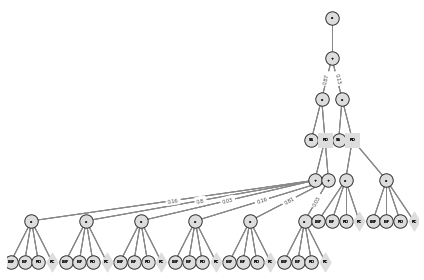

In [3]:
    nodes = (get_structure_stats_dict(spmn)["nodes"])

    plot_spn(spmn, f'{path}/{dataset}/spmn.pdf', feature_labels=feature_labels)




    total_ll = 0
    for instance in test:
        test_data = np.array(instance).reshape(-1, len(feature_names))
        total_ll += log_likelihood(spmn, test_data)[0][0]
    ll = (total_ll/len(test))



    test_data = [[np.nan]*len(feature_names)]
    m = meu(spmn, test_data)
    meus = (m[0])
    
    f = open(f"{path}/{dataset}/stats.txt", "w")
    f.write(f"\n{dataset}")
    f.write(f"\n\tLog Likelihood : {ll}")
    f.write(f"\n\tMEU : {meus}")
    f.write(f"\n\tNodes : {nodes}")
    f.close()